In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


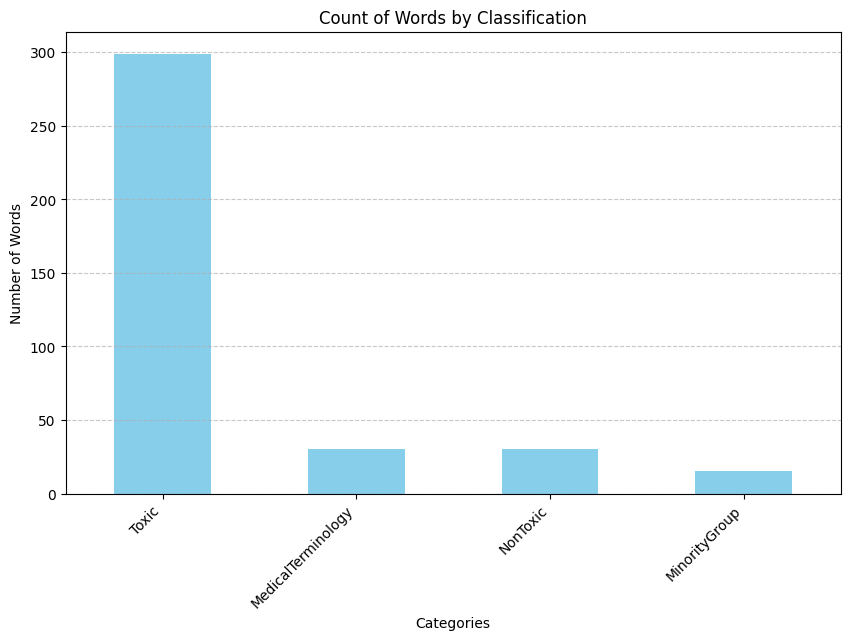

In [2]:
columns = ['Index', 'Word', 'Toxic', 'MedicalTerminology', 'NonToxic', 'MinorityGroup']

output_file_path = '../data/toxic-words.csv'
data = pd.read_csv(output_file_path)

classification_columns = columns[2:]
data[classification_columns] = data[classification_columns].astype(int)
category_counts = data[classification_columns].sum()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Words by Classification')
plt.xlabel('Categories')
plt.ylabel('Number of Words')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/7g/0sqgzqg91cg7_drxrd6npptr0000gn/T/ipykernel_24695/3352444782.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Word_Num'] = filtered_data['Word'].map(word_to_num_75)


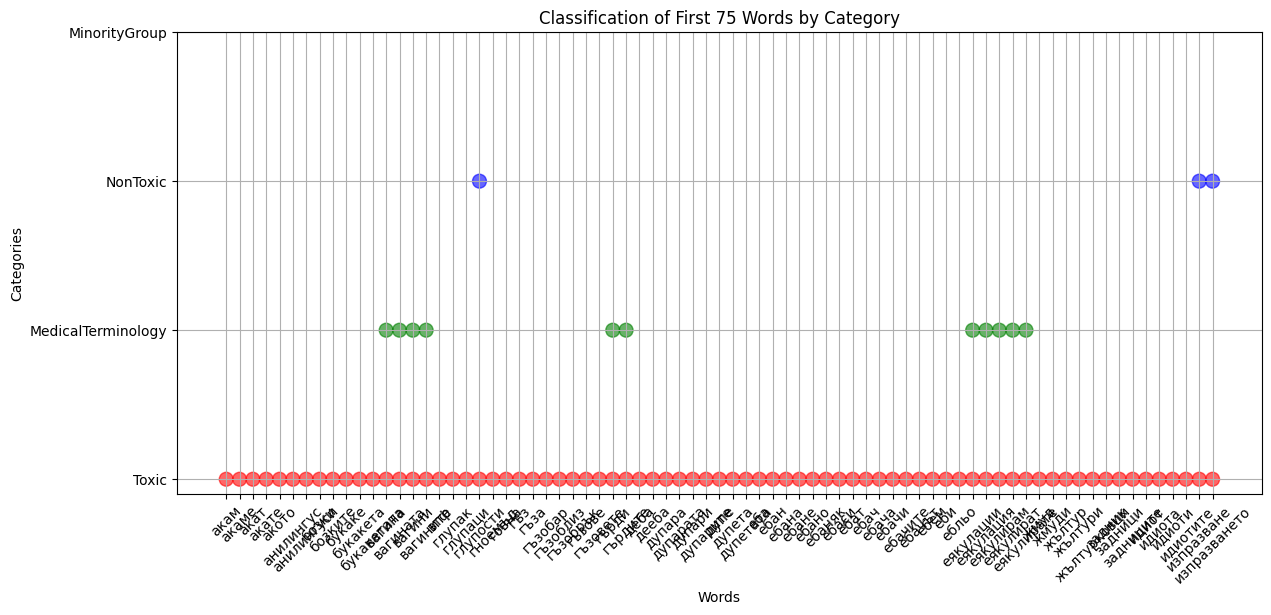

In [3]:
long_format = data.melt(id_vars=['Word'], value_vars=classification_columns, var_name='Category', value_name='Is_Classified')
long_format = long_format[long_format['Is_Classified'] == 1]

word_to_num = {word: i for i, word in enumerate(data['Word'].unique(), 1)}
long_format['Word_Num'] = long_format['Word'].map(word_to_num)

category_to_color = {
    'Toxic': 'red',
    'MedicalTerminology': 'green',
    'NonToxic': 'blue',
    'MinorityGroup': 'purple'
}
long_format['Color'] = long_format['Category'].map(category_to_color)


first_75_words = data['Word'].unique()[:75]
filtered_data = long_format[long_format['Word'].isin(first_75_words)]


word_to_num_75 = {word: i for i, word in enumerate(first_75_words, 1)}
filtered_data['Word_Num'] = filtered_data['Word'].map(word_to_num_75)

plt.figure(figsize=(14, 6))
plt.scatter(filtered_data['Word_Num'], filtered_data['Category'], c=filtered_data['Color'], s=100, alpha=0.6)
plt.title('Classification of First 75 Words by Category')
plt.xlabel('Words')
plt.ylabel('Categories')
plt.xticks(ticks=np.arange(1, len(word_to_num_75) + 1), labels=word_to_num_75.keys(), rotation=45)
plt.yticks(ticks=classification_columns, labels=classification_columns)
plt.grid(True)
plt.show()


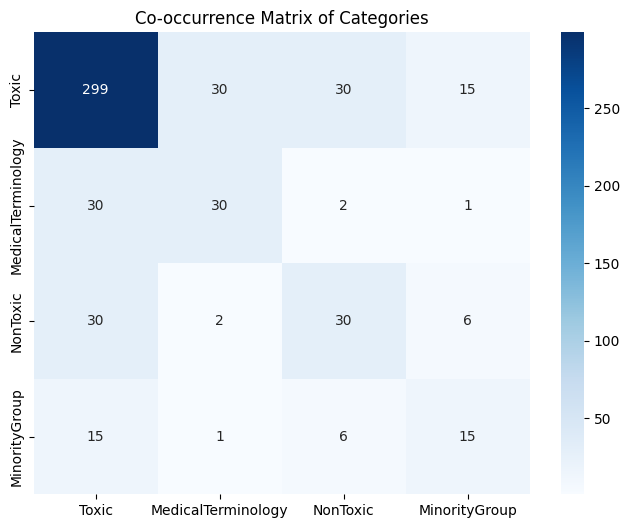

In [4]:
co_occurrence_matrix = data[classification_columns].T.dot(data[classification_columns])

plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Co-occurrence Matrix of Categories")
plt.show()

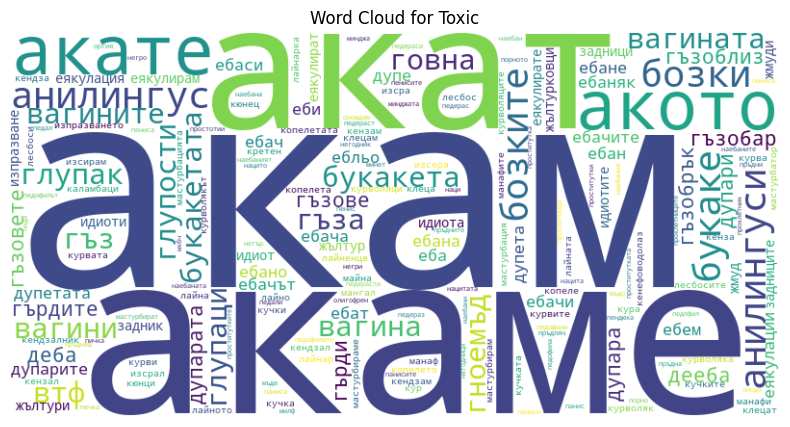

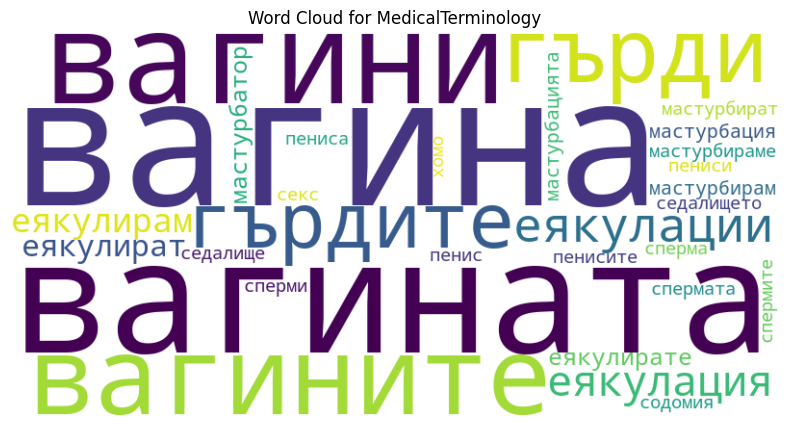

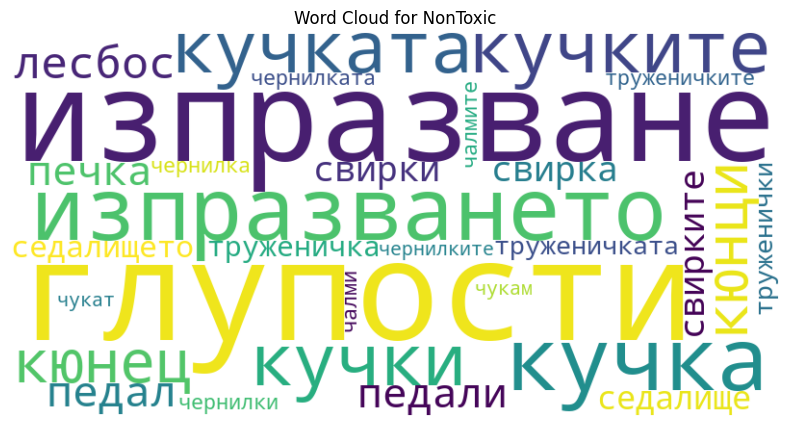

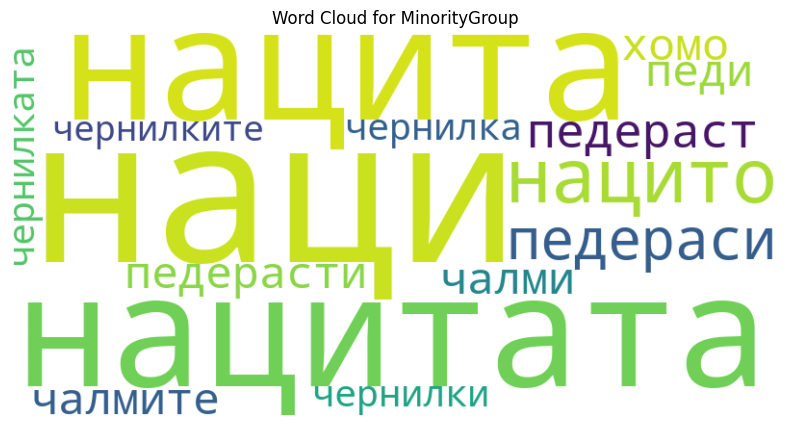

In [5]:
def generate_word_cloud(category):
    filtered_words = data[data[category] == 1]['Word']
    text = ' '.join(filtered_words)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {category}")
    plt.show()

for category in classification_columns:
    generate_word_cloud(category)


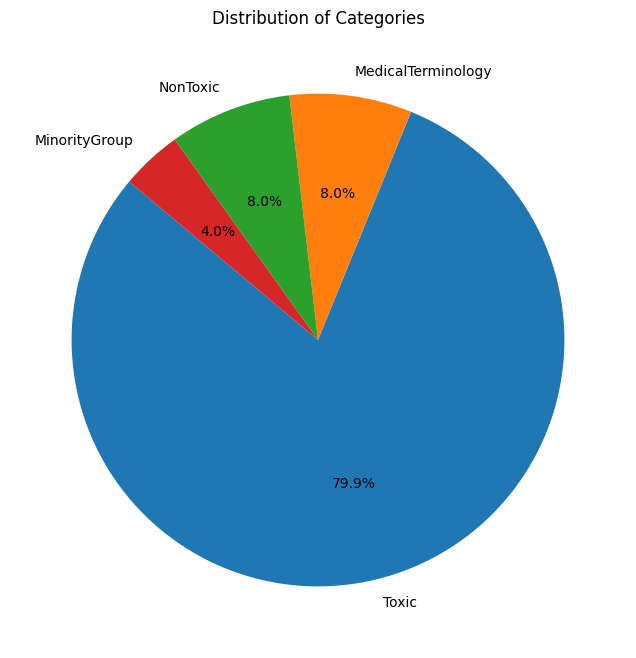

In [6]:
category_counts = data[classification_columns].sum()
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.show()


# EDA sentences

In [7]:
label_columns = ['Toxic', 'MedicalTerminology', 'NonToxic', 'MinorityGroup']
sentences_file_path = '../data/toxic_sentences.csv'
toxic_sentences = pd.read_csv(sentences_file_path)

In [8]:
label_distribution = toxic_sentences[label_columns].sum()
print(label_distribution, '\n')
toxic_sentences['sentence_length'] = toxic_sentences['text'].apply(len)
print(toxic_sentences['sentence_length'].describe(), '\n')
label_correlations = toxic_sentences[label_columns].corr()
print(label_correlations)

Toxic                 2358.0
MedicalTerminology    1222.0
NonToxic               452.0
MinorityGroup          135.0
dtype: float64 

count    4383.000000
mean       98.815195
std        81.050328
min         3.000000
25%        48.000000
50%        79.000000
75%       127.000000
max      1535.000000
Name: sentence_length, dtype: float64 

                       Toxic  MedicalTerminology  NonToxic  MinorityGroup
Toxic               1.000000           -0.666856 -0.362903      -0.187071
MedicalTerminology -0.666856            1.000000 -0.210834      -0.110840
NonToxic           -0.362903           -0.210834  1.000000      -0.060449
MinorityGroup      -0.187071           -0.110840 -0.060449       1.000000


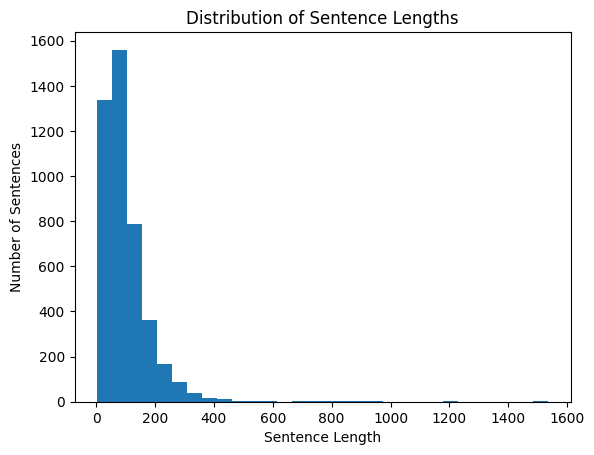

In [9]:

plt.hist(toxic_sentences['sentence_length'], bins=30)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.show()